# Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tqdm.notebook import tqdm
from collections import Counter
from matplotlib import pyplot as plt

import os
import traceback
import time
import random

In [2]:
#saving routines
import pickle
def save_obj(obj, name):
    pickle.dump(obj,open(name + '.pkl', 'wb'), protocol=4)
    
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#quickly plot any data in 2D
from sklearn.decomposition import PCA

def show_data(data, c=None):
    pca = PCA(n_components=2, whiten=True)
    data_2D = pca.fit_transform(data)
    plt.scatter(data_2D[:, 0], data_2D[:, 1], c=c)
    plt.show()
    

In [3]:
#Parallelizing routines

# I mostly borrow this code from http://blog.adeel.io/2016/11/06/parallelize-pandas-map-or-apply/
# https://github.com/rafaelvalero/ParallelTextProcessing/blob/master/parallelizing_text_processing.ipynb
import multiprocessing
import pandas as pd
import numpy as np
from multiprocessing import Pool
import scipy.sparse as sp
#num_partitions = 5
num_cores = multiprocessing.cpu_count()
num_partitions = num_cores-5 # I like to leave some cores for other
#processes
print(num_partitions)



def parallelize_data_cr(df, func):
    parts=[]
    a = np.array_split(df, num_partitions)
    #print(1)
    #del df
    pool = Pool(num_partitions)
    jobs = []
    #print(2)
    #x = pd.concat(pool.map(func, [a,b,c,d,e]))
    finished = [7, 10, 11, 19]
    for i in range(0, num_partitions):
        if i not in finished:
            jobs.append(pool.apply_async(func,(a[i],i)))
    #print(3)
    #x = sp.vstack(pool.map(func, [a,b,c,d,e,f]), format='csr')
    
    for job in jobs:
        parts.append(job.get())
    print(4)
    
    pool.close()
    
    pool.join()
    return parts

27


In [4]:
#Evaluate with ROUGE

from rouge import Rouge 

hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"
reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

#rouge metric based on https://pypi.org/project/rouge/
def my_rouge2(hypothesis, reference):
    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference)
    
    #rouge-1
    r1_f1=scores[0]['rouge-1']['f']
    r1_precision=scores[0]['rouge-1']['p']
    r1_recall=scores[0]['rouge-1']['r']
    
    #rouge-2
    r2_f1=scores[0]['rouge-2']['f']
    r2_precision=scores[0]['rouge-2']['p']
    r2_recall=scores[0]['rouge-2']['r']
    
    return r1_f1, r2_f1, #, precision, recall

my_rouge2(hypothesis, reference)

(0.4786324739396596, 0.2608695605353498)

# Load data

In [5]:
ds = load_obj('ds_merged')
ds.head()

,article_id,article_text,abstract_text,section_names,sections,len_text,len_abstract,sent_ext,word_ext,word_inf,...,best_rouge1_vns_initgreed,best_rouge2_vns_initgreed,len_sum_vns,len_sum_wih,len_sum_vot,len_sum_vns_init_greed,best_summary_gen,best_rouge1_gen,best_rouge2_gen,len_sum_gen
0,astro-ph0202198,[the study of supernovae ( sne ) has greatly a...,[large numbers of supernovae ( sne ) have been...,"[introduction, method, results, future prospec...",[[the study of supernovae ( sne ) has greatly ...,341,12,0.000000,0.897436,0.076004,...,0.484935,0.146763,15,5,15,5,"[once discovered , the study of a particular s...",0.565217,0.157718,12
1,0905.2691,[it is believed that solar magnetic fields are...,[we investigate the emergence of magnetic flux...,"[introduction, observations and data reduction...",[[it is believed that solar magnetic fields ar...,329,11,0.000000,0.884892,0.073258,...,0.629482,0.296000,14,9,9,9,"[, the process of flux emergence occurs on ver...",0.598753,0.288100,11
2,1305.7010,[the origin - destination ( od ) matrix is imp...,[the estimation of the number of passengers wi...,"[introduction, the passenger model, the observ...",[[the origin - destination ( od ) matrix is im...,225,10,0.000000,0.740157,0.074367,...,0.474187,0.119002,19,4,19,14,[+ the purpose of this paper is then to develo...,0.528455,0.130612,10
3,1402.0371,[multiscale dynamics is present in many phenom...,[the classical structure - function ( sf ) met...,"[introduction, detrending analysis and detrend...",[[multiscale dynamics is present in many pheno...,216,15,0.066667,0.949045,0.171659,...,0.767442,0.563333,16,11,11,11,[power - law behavior is observed on a large -...,0.623656,0.354391,15
4,1701.00774,[the @xmath3-transformation has been extensive...,"[given a real number @xmath0 , we study the as...","[introduction, coded negative beta-shift, lap ...",[[the @xmath3-transformation has been extensiv...,353,11,0.000000,0.867925,0.059547,...,0.541176,0.236407,14,4,4,4,[we understand the closure of the set of expan...,0.599496,0.222785,11


# Calculating best possible rouge summary

In [35]:
import random

def crossover(cand1, cand2, n_chromosomes):
    #try:
    genetic_pool = cand1 + cand2
    random.shuffle(genetic_pool)
    #print(n_chromosomes)
    #print(genetic_pool)
    #print(len(genetic_pool))
    offspring = random.sample(genetic_pool, min(n_chromosomes, len(genetic_pool)))
    return offspring
    #except:
        #print(type(cand1))
        #print(type(cand2))
    

def genetic_best_sum(text, abstract, generations, init_sol):
    d=len(text)
    a=len(abstract)
    g_sum='. '.join(abstract)

    #shuffle text sentences
    random.shuffle(text)

    #generate candidates    
    candidates = [text[i:i+a] for i in range(0, len(text), a)] #+ init_sol
    candidates.append(init_sol)
    
    n_offspr = len(candidates) // 2

    for g in range(generations):
        #print(g)
        #crossover all with all
        offsprings = []
        for i in range(len(candidates)):
            #print(i)
            for j in range(i+1, len(candidates)):
                #print(j)
                offsprings.append(crossover(candidates[i], candidates[j], a))

        #evaluate offsprings
        offspring_eval = [my_rouge2(' '.join(ofspr), g_sum)[0] for ofspr in offsprings]
        best_idx = np.array(offspring_eval).argsort()[-n_offspr:]
        candidates = [list(c) for c in np.array(offsprings)[best_idx]]
        #print(candidates)
        #print('Average offspring ROUGE1={} for generation {}'.format(np.array(offspring_eval)[best_idx].mean(), g))
        
    best_summary = offsprings[best_idx[-1]]
    #print(offspring_eval[best_idx[-1]])
    best_rouge = my_rouge2(' '.join(best_summary), g_sum)
    #print(best_rouge)
    return best_summary, best_rouge
    

In [38]:
text = ds.article_text.values[0]
abstract = ds.abstract_text.values[0] 
init_sol = ds.best_summary_wih.values[0]

genetic_best_sum(text, abstract, 8, init_sol)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(['2001 ; miknaitis et al .',
  'fortunately , the common classification of sne ( see filippenko 1997 for a review ) is mostly based on their spectra , with one notable exception which we discuss below .',
  'this is illustrated in the bottom panel of the same figure , where indeed , underluminous sne  ia at early ages ( prior to @xmath87  d ) can not be distinguished from core - collapse sne .',
  'in figure 1 , we compare our data on sne  ia to template colors of normal sne  ia compiled by leibundgut ( 1988 ) .',
  'mexicana astron .',
  'once discovered , the study of a particular sn , and its use as a tool for any of the applications above , is almost always based on spectroscopic verification and classification .',
  'may sometimes be revealed by measuring the photometric light curve of the event .',
  'finally , we have demonstrated the application of our method to a recently discovered sn from the sdss , and we have shown how this technique may become a valuable tool for the ana

In [9]:
type(init_sol)

list

  0%|          | 0/10 [00:00<?, ?it/s]

Average offspring ROUGE1=0.4653508340124972 for generation 0
0.4754990875791582
(0.4754990875791582, 0.12021857425529463)
Average offspring ROUGE1=0.46584569177206786 for generation 0
Average offspring ROUGE1=0.4957182384645757 for generation 1
0.5204991037443324
(0.5204991037443324, 0.11449015601178972)
Average offspring ROUGE1=0.467311203349388 for generation 0
Average offspring ROUGE1=0.49696150418706286 for generation 1
Average offspring ROUGE1=0.512212984823027 for generation 2
0.536115564841071
(0.536115564841071, 0.15458936699842613)
Average offspring ROUGE1=0.45410461869748914 for generation 0
Average offspring ROUGE1=0.48972070829577535 for generation 1
Average offspring ROUGE1=0.5104548923707631 for generation 2
Average offspring ROUGE1=0.5210243644828055 for generation 3
0.5346534603519807
(0.5346534603519807, 0.16887416719091283)
Average offspring ROUGE1=0.4663517179669677 for generation 0
Average offspring ROUGE1=0.49340649863152447 for generation 1
Average offspring ROUGE

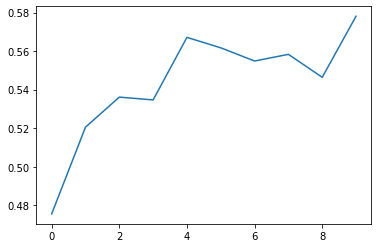

In [81]:
r_of_generation = [genetic_best_sum(text, abstract, i+1)[1][0] for i in tqdm(range(10))]
plt.plot(r_of_generation)

  0%|          | 0/10 [00:00<?, ?it/s]

Average offspring ROUGE1=0.46498176677830794 for generation 0
Average offspring ROUGE1=0.48828658418878323 for generation 1
Average offspring ROUGE1=0.5103921559298378 for generation 2
Average offspring ROUGE1=0.5321078170490431 for generation 3
Average offspring ROUGE1=0.5441910492795853 for generation 4
Average offspring ROUGE1=0.557139383042783 for generation 5
Average offspring ROUGE1=0.5621578595820982 for generation 6
Average offspring ROUGE1=0.5637995639550023 for generation 7
Average offspring ROUGE1=0.5714862254805685 for generation 8
Average offspring ROUGE1=0.5748424881229083 for generation 9
0.5979729679734866
(0.5979729679734866, 0.19322033398356808)
Average offspring ROUGE1=0.46390640835193375 for generation 0
Average offspring ROUGE1=0.4898790223818473 for generation 1
Average offspring ROUGE1=0.5067044614643074 for generation 2
Average offspring ROUGE1=0.5192774967188487 for generation 3
Average offspring ROUGE1=0.5334351332327805 for generation 4
Average offspring ROUG

Average offspring ROUGE1=0.45655603520505955 for generation 0
Average offspring ROUGE1=0.48301128760381673 for generation 1
Average offspring ROUGE1=0.5048745890843359 for generation 2
Average offspring ROUGE1=0.519082623968769 for generation 3
Average offspring ROUGE1=0.5283245720076382 for generation 4
Average offspring ROUGE1=0.5366915555274389 for generation 5
Average offspring ROUGE1=0.5442516979936763 for generation 6
Average offspring ROUGE1=0.5460527799300762 for generation 7
Average offspring ROUGE1=0.5538217095142731 for generation 8
Average offspring ROUGE1=0.5605564131284934 for generation 9
Average offspring ROUGE1=0.5588060342021557 for generation 10
Average offspring ROUGE1=0.5640808610810014 for generation 11
Average offspring ROUGE1=0.5651980852365964 for generation 12
Average offspring ROUGE1=0.5689428342452381 for generation 13
Average offspring ROUGE1=0.5650629300336891 for generation 14
Average offspring ROUGE1=0.5672833183612916 for generation 15
Average offspring

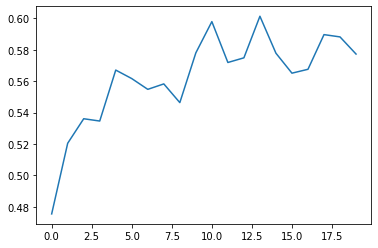

In [83]:
r_of_generation2 = [genetic_best_sum(text, abstract, i+10)[1][0] for i in tqdm(range(10))]
plt.plot(r_of_generation + r_of_generation2)

In [11]:
random.shuffle(text)

In [39]:
import os.path
#prepare the data for classification

def create_classif_data(texts, abstracts, ids, init_sol, c):
    if os.path.isfile('./_gen_greedinit_tmp/best_rouges_gen'+str(c)+'.pkl'):
        #X_sent=load_obj('./_gen_tmp/X_vns'+str(c))
        Art_ID=load_obj('./_gen_greedinit_tmp/Art_ID_gen'+str(c))
        #Y=load_obj('./_gen_tmp/Y_vns'+str(c))
        best_rouges=load_obj('./_gen_greedinit_tmp/best_rouges_gen'+str(c))
        best_sum=load_obj('./_gen_greedinit_tmp/best_sum_gen'+str(c))
        start=len(best_rouges)
        print('Process restarting. Starting from',start)
    else:
        X_sent = []
        #Y = []
        Art_ID = []
        best_rouges = []
        best_sum = []
        start=0
    #art_num=100
    cnt_save=0
    
    for t, a, a_ids, insol in zip(tqdm(texts[start:]), abstracts[start:], ids[start:], init_sol[start:]):
        #print(len(t), len(a))
        if len(t)>len(a) and len(a)>=5:
            try:
                #print(1)
                s, r = genetic_best_sum(t, a, 6, insol)
                #X_sent.append(t)
                Art_ID.append([a_ids for i in range(len(t))])
                #Y.append(issumsent)
                best_rouges.append(r)
                best_sum.append(s)

                
                cnt_save+=1
                
                #save results on the go
                if cnt_save%50==0:
                    print('Saving work', c, 'counter value', cnt_save)
                    #save_obj(X_sent, './_gen_tmp/X_gen'+str(c))
                    #save_obj(Y, './_gen_tmp/Y_vns'+str(c))
                    save_obj(Art_ID, './_gen_greedinit_tmp/Art_ID_gen'+str(c))
                    save_obj(best_rouges, './_gen_greedinit_tmp/best_rouges_gen'+str(c))
                    save_obj(best_sum, './_gen_greedinit_tmp/best_sum_gen'+str(c))
            except Exception as err:
                #print('Err')
                traceback.print_exc()
                continue
        else:
            print('Number of sentences in article are smaller than in abstract OR abstract is shorter than 5 sentences')
    
    #final save
    #save_obj(X_sent, './_gen_tmp/X_vns'+str(c))
    #save_obj(Y, './_gen_tmp/Y_vns'+str(c))
    save_obj(Art_ID, './_gen_greedinit_tmp/Art_ID_gen'+str(c))
    save_obj(best_rouges, './_gen_greedinit_tmp/best_rouges_gen'+str(c))
    save_obj(best_sum, './_gen_greedinit_tmp/best_sum_gen'+str(c))
            
       
    return Art_ID, best_rouges, best_sum #X_sent, Y,

In [40]:
create_classif_data(ds.article_text[0:30], ds.abstract_text[0:30], ds.article_id[0:30], ds.best_summary_wih.values[0:30], 150)

Process restarting. Starting from 0


  0%|          | 0/30 [00:00<?, ?it/s]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


([['astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-ph0202198',
   'astro-

## Parallelize

In [41]:
def create_data(data,c):
    print("Process working on: "+str(c))
    #lem_text=[custom_lemm(t) for t in tqdm(data)]
    idx, best_rouges, best_sum = create_classif_data(data.article_text, 
                                                           data.abstract_text, 
                                                           data.article_id, 
                                                           data.best_summary_wih, 
                                                           c)
    print("Process #%s finished" % c)
    return idx, best_rouges, best_sum

In [42]:
def parallelize_data_cr(df, func):
    parts=[]
    a = np.array_split(df, num_partitions)
    #print(1)
    #del df
    pool = Pool(num_partitions)
    jobs = []
    #print(2)
    #x = pd.concat(pool.map(func, [a,b,c,d,e]))
    finished=[]
    for i in range(0, num_partitions):
        if i not in finished:
            jobs.append(pool.apply_async(func,(a[i],i)))
    #print(3)
    #x = sp.vstack(pool.map(func, [a,b,c,d,e,f]), format='csr')
    
    for job in jobs:
        parts.append(job.get())
    print(4)
    
    pool.close()
    
    pool.join()
    return parts

In [43]:
classif_data=parallelize_data_cr(ds, create_data)

Process working on: 0


  0%|          | 0/632 [00:00<?, ?it/s]

Process working on: 1


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 2


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 3


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 4


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 5


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 6


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 7


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 8


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 9


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 10


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 11


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 12


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 13


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 14


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 15


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 16


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 17


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 18


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 19


  0%|          | 0/631 [00:00<?, ?it/s]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Process working on: 20


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 21


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 22


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 23


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 24


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 25


  0%|          | 0/631 [00:00<?, ?it/s]

Process working on: 26


  0%|          | 0/631 [00:00<?, ?it/s]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda3

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Saving work 8 counter value 50
Saving work 13 counter value 50
Saving work 11 counter value 50
Saving work 24 counter value 50
Saving work 16 counter value 50
Saving work 12 counter value 50
Saving work 6 counter value 50
Saving work 22 counter value 50
Saving work 3 counter value 50
Saving work 9 counter value 50
Saving work 1 counter value 50
Saving work 17 counter value 50
Saving work 10 counter value 50
Saving work 18 counter value 50
Saving work 23 counter value 50
Saving work 21 counter value 50
Saving work 25 counter value 50
Saving work 7 counter value 50
Saving work 0 counter value 50
Saving work 4 counter value 50
Saving work 2 counter value 50
Saving work 20 counter value 50
Saving work 5 counter value 50
Saving work 15 counter value 50
Saving work 19 counter value 50
Saving work 14 counter value 50
Saving work 26 counter value 50
Saving work 13 counter value 100
Saving work 24 counter value 100
Saving work 22 counter value 100
Saving work 16 counter value 100
Saving work 11

Saving work 18 counter value 500
Saving work 5 counter value 450
Saving work 12 counter value 500
Saving work 20 counter value 500
Saving work 26 counter value 450
Saving work 7 counter value 500
Saving work 19 counter value 500
Saving work 8 counter value 500
Saving work 6 counter value 500
Saving work 15 counter value 500
Saving work 11 counter value 550
Saving work 0 counter value 500
Saving work 13 counter value 550
Saving work 25 counter value 450
Saving work 23 counter value 500
Saving work 1 counter value 550
Saving work 2 counter value 500
Saving work 4 counter value 550
Saving work 14 counter value 500
Saving work 17 counter value 550
Saving work 16 counter value 550
Saving work 10 counter value 550
Saving work 22 counter value 550
Saving work 12 counter value 550
Saving work 18 counter value 550
Saving work 24 counter value 550
Saving work 3 counter value 550
Saving work 21 counter value 550
Saving work 5 counter value 500
Saving work 9 counter value 550
Saving work 20 counte

### Put it all together

In [45]:
#y = []
#x = []
br = []
ar_id = []
best_sums = []

for i in tqdm(range(27)):
    #x_n = load_obj('./_gen_tmp/X_gen'+str(i))
    #y_n = load_obj('./_gen_tmp/Y_gen'+str(i))
    br_n = load_obj('./_gen_greedinit_tmp/best_rouges_gen'+str(i))
    ar_id_n = load_obj('./_gen_greedinit_tmp/Art_ID_gen'+str(i))
    best_sums_n = load_obj('./_gen_greedinit_tmp/best_sum_gen'+str(i))
    
    print(i, len(br_n), len(ar_id_n), len(best_sums_n))#len(x_n), len(y_n), len(x_n)-len(y_n), 
    
    #x = x + x_n
    #y = y + y_n
    br = br + br_n
    ar_id = ar_id + ar_id_n
    best_sums = best_sums +best_sums_n
    
print(len(br), len(ar_id),  len(best_sums))#len(x),len(y),len(x)-len(y),

  0%|          | 0/27 [00:00<?, ?it/s]

0 632 632 632
1 631 631 631
2 631 631 631
3 631 631 631
4 631 631 631
5 631 631 631
6 631 631 631
7 631 631 631
8 631 631 631
9 631 631 631
10 631 631 631
11 631 631 631
12 631 631 631
13 631 631 631
14 631 631 631
15 631 631 631
16 631 631 631
17 631 631 631
18 631 631 631
19 631 631 631
20 631 631 631
21 631 631 631
22 631 631 631
23 631 631 631
24 631 631 631
25 631 631 631
26 631 631 631
17038 17038 17038


In [46]:
ds_gen = pd.DataFrame()
ds_gen['best_summary_gen_greedinit'] = best_sums#[[s for s, l in zip(art_sents, labels) if l == 1] for art_sents, labels in zip(x, y)]
ds_gen['best_rouge1_gen_greedinit'] = [r[0] for r in br]
ds_gen['best_rouge2_gen_greedinit'] = [r[1] for r in br]
ds_gen['article_id'] = [ids[0] for ids in ar_id]
ds_gen.head()

,best_summary_gen_greedinit,best_rouge1_gen_greedinit,best_rouge2_gen_greedinit,article_id
0,[the method presented here can become signific...,0.568182,0.153094,astro-ph0202198
1,[an important result is that 23% of the loops ...,0.598778,0.282209,0905.2691
2,[the ad - hoc estimation is plotted in green ....,0.524109,0.113684,1305.7010
3,[this procedure is designated as detrending an...,0.736508,0.487261,1402.0371
4,[the previous theorem can be proved also just ...,0.560185,0.200000,1701.00774


In [47]:
ds_merged = load_obj('ds_merged')
ds_merged.shape

(17038, 31)

In [48]:
#merge two dataframes
ds_merged = pd.merge(ds_merged, ds_gen, on='article_id')
ds_merged.head()

,article_id,article_text,abstract_text,section_names,sections,len_text,len_abstract,sent_ext,word_ext,word_inf,...,len_sum_wih,len_sum_vot,len_sum_vns_init_greed,best_summary_gen,best_rouge1_gen,best_rouge2_gen,len_sum_gen,best_summary_gen_greedinit,best_rouge1_gen_greedinit,best_rouge2_gen_greedinit
0,astro-ph0202198,[the study of supernovae ( sne ) has greatly a...,[large numbers of supernovae ( sne ) have been...,"[introduction, method, results, future prospec...",[[the study of supernovae ( sne ) has greatly ...,341,12,0.000000,0.897436,0.076004,...,5,15,5,"[once discovered , the study of a particular s...",0.565217,0.157718,12,[the method presented here can become signific...,0.568182,0.153094
1,0905.2691,[it is believed that solar magnetic fields are...,[we investigate the emergence of magnetic flux...,"[introduction, observations and data reduction...",[[it is believed that solar magnetic fields ar...,329,11,0.000000,0.884892,0.073258,...,9,9,9,"[, the process of flux emergence occurs on ver...",0.598753,0.288100,11,[an important result is that 23% of the loops ...,0.598778,0.282209
2,1305.7010,[the origin - destination ( od ) matrix is imp...,[the estimation of the number of passengers wi...,"[introduction, the passenger model, the observ...",[[the origin - destination ( od ) matrix is im...,225,10,0.000000,0.740157,0.074367,...,4,19,14,[+ the purpose of this paper is then to develo...,0.528455,0.130612,10,[the ad - hoc estimation is plotted in green ....,0.524109,0.113684
3,1402.0371,[multiscale dynamics is present in many phenom...,[the classical structure - function ( sf ) met...,"[introduction, detrending analysis and detrend...",[[multiscale dynamics is present in many pheno...,216,15,0.066667,0.949045,0.171659,...,11,11,11,[power - law behavior is observed on a large -...,0.623656,0.354391,15,[this procedure is designated as detrending an...,0.736508,0.487261
4,1701.00774,[the @xmath3-transformation has been extensive...,"[given a real number @xmath0 , we study the as...","[introduction, coded negative beta-shift, lap ...",[[the @xmath3-transformation has been extensiv...,353,11,0.000000,0.867925,0.059547,...,4,4,4,[we understand the closure of the set of expan...,0.599496,0.222785,11,[the previous theorem can be proved also just ...,0.560185,0.200000


In [49]:
#ds_merged['len_sum_vns'] = [len(a) for a in ds_merged['best_summary_vns'].values]
#ds_merged['len_sum_wih'] = [len(a) for a in ds_merged['best_summary_wih'].values]
#ds_merged['len_sum_vot'] = [len(a) for a in ds_merged['voted_summary'].values]
ds_merged['len_sum_gen_greedinit'] = [len(a) for a in ds_merged['best_summary_gen_greedinit'].values]

In [51]:
save_obj(ds_merged, 'ds_merged')

In [50]:
ds_merged.describe()

,len_text,len_abstract,sent_ext,word_ext,word_inf,best_rouge1_wih,best_rouge2_wih,best_rouge1_vns,best_rouge2_vns,voted_r1,...,len_sum_vns,len_sum_wih,len_sum_vot,len_sum_vns_init_greed,best_rouge1_gen,best_rouge2_gen,len_sum_gen,best_rouge1_gen_greedinit,best_rouge2_gen_greedinit,len_sum_gen_greedinit
count,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,...,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000,17038.000000
mean,263.444360,11.768576,0.009705,0.859045,0.099746,0.552754,0.233332,0.552338,0.211357,0.572324,...,15.334312,7.012678,11.303850,9.545252,0.581534,0.238658,11.768576,0.593162,0.253327,11.768576
std,102.651972,2.141314,0.043253,0.093133,0.029403,0.083730,0.103396,0.066306,0.079049,0.074507,...,4.919018,2.913752,5.394884,5.052838,0.073449,0.091883,2.141314,0.075162,0.101608,2.141314
min,100.000000,10.000000,0.000000,0.112000,0.019078,0.041428,0.009938,0.074289,0.011204,0.094595,...,11.000000,1.000000,3.000000,3.000000,0.085583,0.006299,10.000000,0.088145,0.012346,10.000000
25%,179.000000,10.000000,0.000000,0.826087,0.078901,0.507865,0.164921,0.520117,0.158035,0.533890,...,13.000000,5.000000,7.000000,6.000000,0.546426,0.177320,10.000000,0.556215,0.186258,10.000000
50%,252.000000,11.000000,0.000000,0.880000,0.095601,0.552147,0.212286,0.555740,0.199250,0.571093,...,14.000000,7.000000,12.000000,8.000000,0.587440,0.225108,11.000000,0.595960,0.236088,11.000000
75%,338.000000,13.000000,0.000000,0.918750,0.116252,0.599237,0.275685,0.590308,0.251441,0.610541,...,16.000000,8.000000,14.000000,13.000000,0.625225,0.285022,13.000000,0.634795,0.299342,13.000000
max,500.000000,20.000000,0.900000,1.000000,0.290541,0.969005,0.932897,0.837662,0.778502,0.969005,...,89.000000,41.000000,89.000000,86.000000,0.861244,0.834771,20.000000,0.915739,0.878545,20.000000


In [53]:
ds_merged.to_csv('ds_merged_5_methods.csv', ';', index=False)

# Visualize results

In [54]:
ds_merged.columns

Index(['article_id', 'article_text', 'abstract_text', 'section_names',
       'sections', 'len_text', 'len_abstract', 'sent_ext', 'word_ext',
       'word_inf', 'best_rouge1_wih', 'best_rouge2_wih', 'best_summary_wih',
       'best_summary_vns', 'best_rouge1_vns', 'best_rouge2_vns',
       'voted_summary', 'voted_method', 'voted_r1', 'voted_r2',
       'best_summary_vns_initgreed', 'best_rouge1_vns_initgreed',
       'best_rouge2_vns_initgreed', 'len_sum_vns', 'len_sum_wih',
       'len_sum_vot', 'len_sum_vns_init_greed', 'best_summary_gen',
       'best_rouge1_gen', 'best_rouge2_gen', 'len_sum_gen',
       'best_summary_gen_greedinit', 'best_rouge1_gen_greedinit',
       'best_rouge2_gen_greedinit', 'len_sum_gen_greedinit'],
      dtype='object')

Text(0, 0.5, 'ROUGE-1 score')

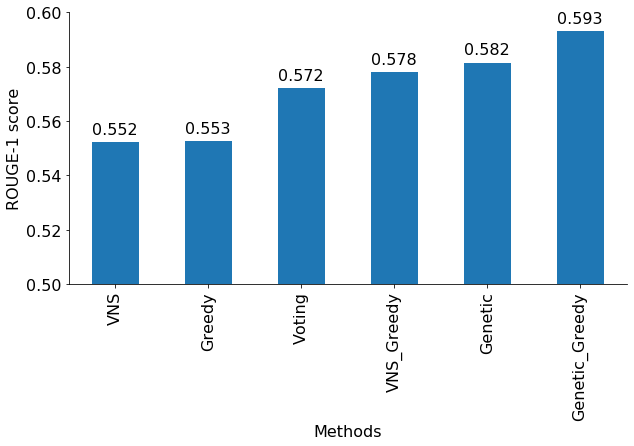

In [96]:
ds_plt = ds_merged[['best_rouge1_wih', #'best_rouge2_wih', 
           'best_rouge1_vns', #'best_rouge2_vns',
           'voted_r1', #'voted_r2',
           'best_rouge1_vns_initgreed', #'best_rouge2_vns_initgreed',
           'best_rouge1_gen', #'best_rouge2_gen',
           'best_rouge1_gen_greedinit', #'best_rouge2_gen_greedinit'
          ]].mean()
ds_plt.index = ['Greedy', 'VNS', 'Voting', 'VNS_Greedy', 'Genetic', 'Genetic_Greedy']
ax = ds_plt.sort_values().plot(kind='bar', ylim=(0.5, 0.6), figsize=(10, 5))

for p in ax.patches:
    #print(p.get_x())
    ax.annotate(str(round(p.get_height(), 3)), (p.get_x(), p.get_height() * 1.005), fontsize=16, ha='left')
    
# Remove the frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# Enlarge the font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel('Methods', fontsize=16)
plt.ylabel('ROUGE-1 score', fontsize=16)

Text(0, 0.5, 'ROUGE-2 score')

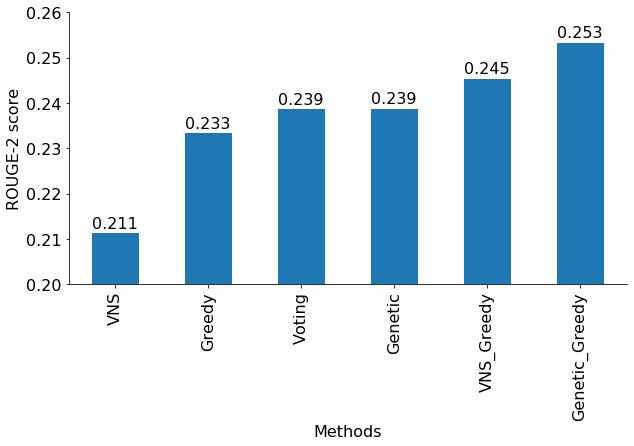

In [99]:
ds_plt2 = ds_merged[['best_rouge2_wih', 
           'best_rouge2_vns',
           'voted_r2',
           'best_rouge2_vns_initgreed',
           'best_rouge2_gen',
           'best_rouge2_gen_greedinit'
          ]].mean()
ds_plt2.index = ['Greedy', 'VNS', 'Voting', 'VNS_Greedy', 'Genetic', 'Genetic_Greedy']
ax = ds_plt2.sort_values().plot(kind='bar', ylim=(0.2,0.26), figsize=(10, 5))

for p in ax.patches:
    #print(p.get_x())
    ax.annotate(str(round(p.get_height(), 3)), (p.get_x(), p.get_height() * 1.005), fontsize=16, ha='left')
    
# Remove the frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# Enlarge the font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel('Methods', fontsize=16)
plt.ylabel('ROUGE-2 score', fontsize=16)

In [52]:
ds_merged.describe().to_excel('results 6 methods.xlsx', sheet_name='description')

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 6 Text yticklabel objects>)

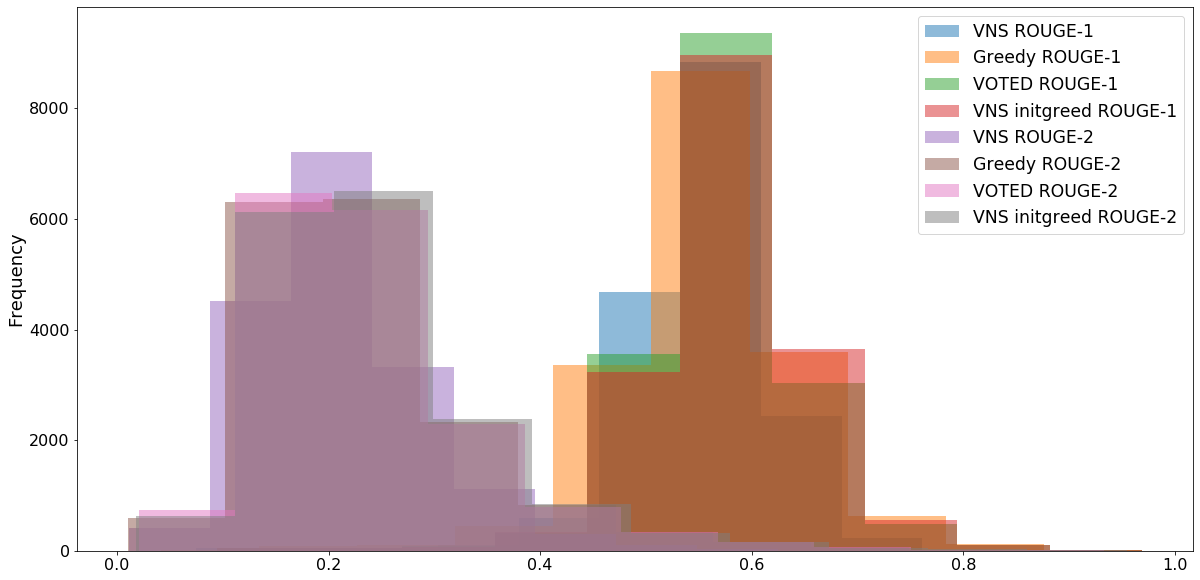

In [50]:
ds_merged['best_rouge1_vns'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge1_wih'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['voted_r1'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge1_vns_initgreed'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge2_vns'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge2_wih'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['voted_r2'].plot.hist(figsize=(20, 10), alpha=0.5)
ds_merged['best_rouge2_vns_initgreed'].plot.hist(figsize=(20, 10), alpha=0.5)
plt.legend(['VNS ROUGE-1', 'Greedy ROUGE-1', 'VOTED ROUGE-1', 'VNS initgreed ROUGE-1', 'VNS ROUGE-2', 'Greedy ROUGE-2', 'VOTED ROUGE-2', 'VNS initgreed ROUGE-2'], fontsize='xx-large')
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)